In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dropout, Dense

In [3]:
base_path = '/content/drive/MyDrive/IRMASdataset'

X_crnn = np.load(os.path.join(base_path, 'X_rnn.npy'))
y_crnn = np.load(os.path.join(base_path, 'y_rnn.npy'))

In [4]:
#Since we are using rnn.npy we need to redimension in order for it to fit in the CRNN

# Add channel dimension for Conv2D
X_crnn = X_crnn.reshape(X_crnn.shape[0], X_crnn.shape[1], X_crnn.shape[2], 1)  # shape: (2159, 130, 153, 1)

print(X_crnn.shape)

(2159, 130, 153, 1)


In [5]:
y_crnn_cat = to_categorical(y_crnn, num_classes=4)

In [6]:
# === Apply 50% / 100% stratified subset to the RNN arrays ===
import numpy as np
import os
import pandas as pd

# Toggle here:
DATASET_PORTION = "100"   # "100" or "50"
SPLIT_SEED = 42

class_names = ['Clarinet', 'Saxophone', 'Flute', 'Trumpet']  # just for printouts

def print_class_counts(y_int, names):
    ids, cnts = np.unique(y_int, return_counts=True)
    for i, c in zip(ids, cnts):
        print(f"{names[i]}: {c} samples")

def stratified_half_indices(y_int, seed=42):
    rng = np.random.RandomState(seed)
    idx_sel = []
    for cls in np.unique(y_int):
        cls_idx = np.where(y_int == cls)[0]
        n = int(np.floor(len(cls_idx) * 0.5))
        chosen = rng.choice(cls_idx, size=n, replace=False)
        idx_sel.extend(chosen)
    return np.array(sorted(idx_sel), dtype=int)

print("🔍 Full dataset distribution:")
print_class_counts(y_crnn, class_names)

if DATASET_PORTION == "50":
    print(f"\n📉 Using stratified 50% of the dataset with seed = {SPLIT_SEED}")
    idx_sel = stratified_half_indices(y_crnn, seed=SPLIT_SEED)

    # Save manifest (for reproducibility)
    manifest_path = os.path.join(base_path, "subset_50_manifest_rnn.csv")
    pd.DataFrame({"index": idx_sel, "label": y_crnn[idx_sel]}).to_csv(manifest_path, index=False)
    print(f"📝 Saved subset manifest: {manifest_path}")

    # Apply subset
    X_crnn       = X_crnn[idx_sel]
    y_crnn       = y_crnn[idx_sel]
    y_crnn_cat   = y_crnn_cat[idx_sel]

    print("\n📊 Subset distribution:")
    print_class_counts(y_crnn, class_names)
    print("Shapes now -> X:", X_crnn.shape, " y:", y_crnn.shape, " y_cat:", y_crnn_cat.shape)
else:
    print("\n✅ Using 100% of the dataset (no reduction).")

🔍 Full dataset distribution:
Clarinet: 505 samples
Saxophone: 626 samples
Flute: 451 samples
Trumpet: 577 samples

✅ Using 100% of the dataset (no reduction).


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_crnn, y_crnn_cat, test_size=0.2, stratify=y_crnn, random_state=42 )

print("✅ X_train shape:", X_train.shape)
print("✅ X_test shape:", X_test.shape)
print("✅ y_train shape:", y_train.shape)
print("✅ y_test shape:", y_test.shape)

✅ X_train shape: (1727, 130, 153, 1)
✅ X_test shape: (432, 130, 153, 1)
✅ y_train shape: (1727, 4)
✅ y_test shape: (432, 4)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise

augment = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.02, width_factor=0.08, fill_mode='nearest'),
    GaussianNoise(0.02)
], name="augment")

In [18]:
#THIS WILL BE USED FOR CRNN

import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise
augment = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.1),
    GaussianNoise(0.05)  # lower noise
], name="augment")

In [10]:
#CRNN architecture 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, LSTM, GRU, Bidirectional, Dense, BatchNormalization, Input

def build_crnn_model_1(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    #Augment
    model.add(augment)

    #CNN Portion
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Reshape to (timesteps, features) for LSTM
    model.add(Reshape((model.output_shape[1], model.output_shape[2] * model.output_shape[3])))

    #RNN Portion

    model.add(LSTM(128))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))
    return model


input_shape = X_train.shape[1:]

model = build_crnn_model_1(input_shape, num_classes=4)

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05), metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augment (Sequential)            │ (None, 130, 153, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 130, 153, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 130, 153, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 65, 76, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 65, 76, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 65, 76, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 65, 76, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 1216)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       688,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 694,148 (2.65 MB)

 Trainable params: 694,052 (2.65 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [11]:
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.3789 - loss: 1.3704 - val_accuracy: 0.4537 - val_loss: 1.2481
Epoch 2/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4993 - loss: 1.1458 - val_accuracy: 0.3773 - val_loss: 1.3908
Epoch 3/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6041 - loss: 1.0346 - val_accuracy: 0.4630 - val_loss: 1.2839
Epoch 4/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6210 - loss: 0.9563 - val_accuracy: 0.4653 - val_loss: 1.2730
Epoch 5/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6543 - loss: 0.9275 - val_accuracy: 0.4097 - val_loss: 1.3773
Epoch 6/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7047 - loss: 0.8151 - val_accuracy: 0.4051 - val_loss: 1.3930
Epoch 7/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7797 - loss: 0.7329 - val_accuracy: 0.4074 - val_loss: 1.3895
Epoch 8/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7984 - loss: 0.6806 - val_accuracy: 0.4560 - 

KeyboardInterrupt: 

In [ ]:
!pip install tensorflow-addons

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [19]:
#CRNN archtiecture 2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, GRU, Bidirectional, Dense, BatchNormalization, Input
from tensorflow.keras import regularizers
#import tensorflow_addons as tfa  # SWA

tf.keras.backend.clear_session()
l2 = regularizers.l2(1e-4)


def build_crnn_model_2(input_shape, num_classes):
    model2 = Sequential()

    # augmentation layer
    model2.add(Input(shape=input_shape))
    model2.add(augment)

    #CNN Portion
    model2.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=input_shape, kernel_regularizer=l2))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((1, 2)))
    model2.add(Dropout(0.15))

    model2.add(Conv2D(64, (3, 3), activation='relu',padding='same', kernel_regularizer=l2))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((1, 2)))
    model2.add(Dropout(0.15))

    model2.add(Conv2D(128, (3, 3), activation='relu',padding='same', kernel_regularizer=l2))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((1, 2)))
    model2.add(Dropout(0.20))

    #RESHAPING FOR RNN
    print("Pre-RNN shape:", model2.output_shape)
    Tprime = model2.output_shape[1]               # time steps (axis 1)
    Fprime = model2.output_shape[2]
    Cprime = model2.output_shape[3]
    model2.add(Reshape((Tprime, Fprime * Cprime)))  # (timesteps, features)

    #RNN Portion
    model2.add(Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2)))
    model2.add(Dropout(0.20))
    model2.add(Bidirectional(GRU(64, kernel_regularizer=l2)))
    model2.add(Dropout(0.20))


    model2.add(Dense(num_classes, activation='softmax'))
    return model2

    # ---- Manual SWA callback (no extra deps) ----
class ManualSWA(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, freq=1):
        super().__init__()
        self.start_epoch = start_epoch
        self.freq = freq
        self.n_averaged = 0
        self.swa_weights = None

    def on_epoch_end(self, epoch, logs=None):
        e = epoch + 1
        if e >= self.start_epoch and ((e - self.start_epoch) % self.freq == 0):
            weights = self.model.get_weights()
            if self.swa_weights is None:
                self.swa_weights = [w.copy() for w in weights]
                self.n_averaged = 1
            else:
                for i in range(len(weights)):
                    self.swa_weights[i] = (self.n_averaged * self.swa_weights[i] + weights[i]) / (self.n_averaged + 1)
                self.n_averaged += 1

    def assign_swa_weights(self, model):
        if self.swa_weights is not None:
            model.set_weights(self.swa_weights)

input_shape = X_train.shape[1:]

model2 = build_crnn_model_2(input_shape, num_classes=4)
opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)  # clip to stabilize long seqs
model2.compile(optimizer=opt,  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.00), metrics=['accuracy'])

model2.summary()

Pre-RNN shape: (None, 130, 19, 128)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augment (Sequential)            │ (None, 130, 153, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 130, 153, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 153, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 130, 76, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 130, 76, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 130, 76, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 130, 76, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 130, 38, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 130, 38, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 130, 38, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 130, 38, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 130, 19, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 130, 19, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 130, 2432)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 130, 256)       │     1,967,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 130, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,185,348 (8.34 MB)

 Trainable params: 2,184,900 (8.33 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
rlrop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    'best_m2_by_valacc.h5', monitor='val_accuracy',
    mode='max', save_best_only=True, verbose=1
)
EPOCHS = 70
swa_cb = ManualSWA(start_epoch=int(0.6 * EPOCHS), freq=1)

history2 = model2.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test),callbacks=[rlrop, ckpt, swa_cb])

# --- Evaluate SWA-averaged weights ---
swa_cb.assign_swa_weights(model2)
print("\nEvaluating SWA-averaged weights:")
model2.evaluate(X_test, y_test, batch_size=64, verbose=1)

# --- Also evaluate the best single epoch (val_accuracy checkpoint) ---
print("\nEvaluating best single epoch (val_accuracy checkpoint):")
model2.load_weights('best_m2_by_valacc.h5')
model2.evaluate(X_test, y_test, batch_size=64, verbose=1)

Epoch 1/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3684 - loss: 1.5759
Epoch 1: val_accuracy improved from -inf to 0.46065, saving model to best_m2_by_valacc.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.3690 - loss: 1.5747 - val_accuracy: 0.4606 - val_loss: 1.3751 - learning_rate: 3.0000e-04
Epoch 2/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5232 - loss: 1.2798
Epoch 2: val_accuracy did not improve from 0.46065
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.5232 - loss: 1.2797 - val_accuracy: 0.4213 - val_loss: 1.4377 - learning_rate: 3.0000e-04
Epoch 3/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6000 - loss: 1.1356
Epoch 3: val_accuracy did not improve from 0.46065
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.5998 - loss: 1.1361 - val_accuracy: 0.4329 - val_loss: 1.5695 - learning_rate: 3.0000e-04
Epoch 4/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6421 - loss: 1.0556
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 4: val_accuracy improved from 0.46065 to 0.47222, saving model to best_m2_by_valacc.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.6419 - loss: 1.0560 - val_accuracy: 0.4722 - val_loss: 1.4470 - learning_rate: 3.0000e-04
Epoch 5/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7355 - loss: 0.9162
Epoch 5: val_accuracy did not improve from 0.47222
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.7353 - loss: 0.9165 - val_accuracy: 0.4259 - val_loss: 1.5077 - learning_rate: 1.5000e-04
Epoch 6/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7516 - loss: 0.8443
Epoch 6: val_accuracy did not improve from 0.47222
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.7515 - loss: 0.8444 - val_accuracy: 0.4028 - val_loss: 1.6445 - learning_rate: 1.5000e-04
Epoch 7/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7761 - loss: 0.7964
Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 7: val_accuracy did not improve from 0.47222
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.7763 - loss: 0.7963 

KeyboardInterrupt: 

In [49]:
# ==== METRICS, FIGURES, SAVING (single-label, multi-class) ====
# Requires: model, X_test, y_test, base_path

import os, json, numpy as np, matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score,
    balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef,
    average_precision_score, precision_recall_fscore_support
)

# --- identify this run ---
exp_id = "CRNN_M2_50_holdout"   # e.g. CNN_M1_50_holdout, CNN_M2_100_holdout, ...

# --- paths ---
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
out_dir = base_path
prefix = os.path.join(out_dir, f"{exp_id}_{ts}")

# --- predictions ---
y_true = y_test.argmax(axis=1)
y_prob = model2.predict(X_test, verbose=0)
y_pred = y_prob.argmax(axis=1)

class_names = ['Clarinet','Saxophone','Flute','Trumpet']
clarinet_idx = 0

# --- overall metrics ---
acc     = accuracy_score(y_true, y_pred)
prec_m  = precision_score(y_true, y_pred, average='macro',   zero_division=0)
prec_w  = precision_score(y_true, y_pred, average='weighted',zero_division=0)
rec_m   = recall_score(y_true, y_pred, average='macro',      zero_division=0)
rec_w   = recall_score(y_true, y_pred, average='weighted',   zero_division=0)
f1_m    = f1_score(y_true, y_pred, average='macro')
f1_w    = f1_score(y_true, y_pred, average='weighted')
bacc    = balanced_accuracy_score(y_true, y_pred)
kappa   = cohen_kappa_score(y_true, y_pred)
mcc     = matthews_corrcoef(y_true, y_pred)
top2    = (np.argsort(y_prob, axis=1)[:, -2:] == y_true[:, None]).any(axis=1).mean()

# --- per-class report ---
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, digits=3)
report_text = classification_report(y_true, y_pred, target_names=class_names, digits=3)

# --- overall confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
plt.title(f"Confusion Matrix — {exp_id}")
plt.tight_layout()
cm_path = f"{prefix}_cm.png"
plt.savefig(cm_path, dpi=300)
plt.close()

# --- one-vs-rest confusion matrices (each instrument) ---
ovr_paths = {}
for i, name in enumerate(class_names):
    y_true_bin = (y_true == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    cm_i = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
    disp_i = ConfusionMatrixDisplay(confusion_matrix=cm_i, display_labels=["Not Present","Present"])
    fig, ax = plt.subplots(figsize=(4,4))
    disp_i.plot(ax=ax, cmap='Purples', values_format='d', colorbar=False)
    plt.title(f"{name} OvR Confusion Matrix — {exp_id}")
    plt.tight_layout()
    pth = f"{prefix}_cm_{name.replace(' ','_')}_ovr.png"
    plt.savefig(pth, dpi=300)
    plt.close()
    ovr_paths[name] = pth

# --- clarinet-focused metrics (binary + PR-AUC) ---
y_true_c = (y_true == clarinet_idx).astype(int)
y_pred_c = (y_pred == clarinet_idx).astype(int)
prec_c, rec_c, f1_c, _ = precision_recall_fscore_support(y_true_c, y_pred_c, average='binary', zero_division=0)
pr_auc_c = average_precision_score(y_true_c, y_prob[:, clarinet_idx])

# --- bundle + save metrics ---
metrics = {
    "exp_id": exp_id,
    "timestamp": ts,
    "overall": {
        "accuracy": float(acc),
        "precision_macro": float(prec_m),
        "recall_macro": float(rec_m),
        "f1_macro": float(f1_m),
        "precision_weighted": float(prec_w),
        "recall_weighted": float(rec_w),
        "f1_weighted": float(f1_w),
        "balanced_accuracy": float(bacc),
        "cohen_kappa": float(kappa),
        "mcc": float(mcc),
        "top2_accuracy": float(top2),
    },
    "per_class_report": report_dict,
    "clarinet_specific": {
        "precision": float(prec_c),
        "recall": float(rec_c),
        "f1": float(f1_c),
        "pr_auc": float(pr_auc_c),
        "support": int(y_true_c.sum()),
    },
    "artifacts": {
        "cm_overall_png": cm_path,
        "cm_ovr_pngs": ovr_paths,
    }
}

json_path = f"{prefix}_metrics.json"
txt_path  = f"{prefix}_metrics.txt"
with open(json_path, "w") as f: json.dump(metrics, f, indent=2)
with open(txt_path, "w") as f:
    f.write(
        f"Experiment: {exp_id}\n"
        f"Accuracy: {acc:.3f}\n"
        f"Macro  — Precision: {prec_m:.3f}  Recall: {rec_m:.3f}  F1: {f1_m:.3f}\n"
        f"Weighted — Precision: {prec_w:.3f}  Recall: {rec_w:.3f}  F1: {f1_w:.3f}\n"
        f"Balanced Acc: {bacc:.3f} | Cohen's κ: {kappa:.3f} | MCC: {mcc:.3f}\n"
        f"Top-2 Acc: {top2:.3f}\n\n"
        "Per-class precision/recall/F1/support:\n"
        f"{report_text}\n\n"
        f"Clarinet — Precision: {prec_c:.3f}, Recall: {rec_c:.3f}, F1: {f1_c:.3f}, PR-AUC: {pr_auc_c:.3f}\n"
        f"Overall CM: {cm_path}\n"
        f"OvR CMs: {ovr_paths}\n"
    )

# --- save predictions for reproducibility ---
np.save(f"{prefix}_y_true.npy", y_true)
np.save(f"{prefix}_y_pred.npy", y_pred)
np.save(f"{prefix}_y_prob.npy", y_prob)

# --- save the trained model ---
model_path = f"{prefix}_model.keras"   # Keras native format
model2.save(model_path)

print("Saved:")
print("  Metrics JSON:", json_path)
print("  Metrics TXT :", txt_path)
print("  Overall CM  :", cm_path)
for name, path in ovr_paths.items():
    print(f"  OvR CM ({name}): {path}")
print("  y_true/y_pred/y_prob .npy files")
print("  Model:", model_path)


Saved:
  Metrics JSON: /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_metrics.json
  Metrics TXT : /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_metrics.txt
  Overall CM  : /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_cm.png
  OvR CM (Clarinet): /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_cm_Clarinet_ovr.png
  OvR CM (Saxophone): /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_cm_Saxophone_ovr.png
  OvR CM (Flute): /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_cm_Flute_ovr.png
  OvR CM (Trumpet): /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_cm_Trumpet_ovr.png
  y_true/y_pred/y_prob .npy files
  Model: /content/drive/MyDrive/IRMASdataset/CRNN_M2_50_holdout_20250824-124521_model.keras



📋 Classification Report:
              precision    recall  f1-score   support

    Clarinet      0.684     0.520     0.591        50
   Saxophone      0.671     0.746     0.707        63
       Flute      0.667     0.578     0.619        45
     Trumpet      0.681     0.810     0.740        58

    accuracy                          0.676       216
   macro avg      0.676     0.664     0.664       216
weighted avg      0.676     0.676     0.671       216



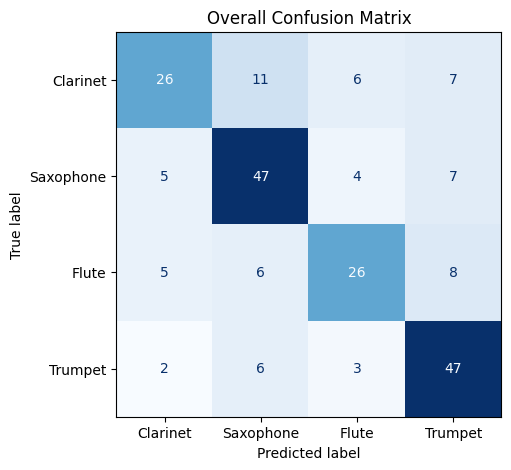

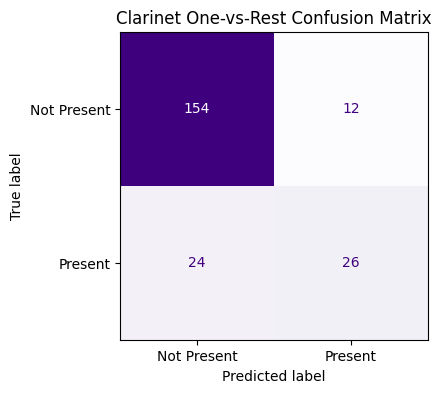

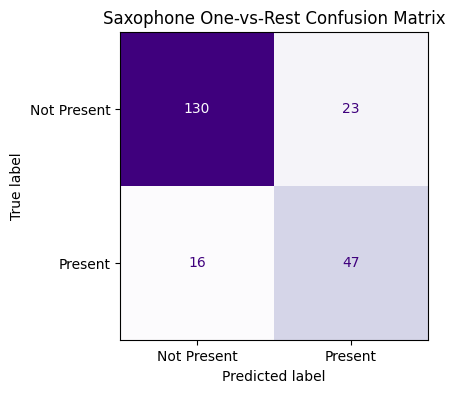

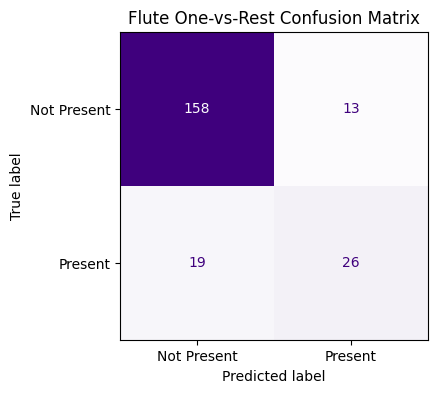

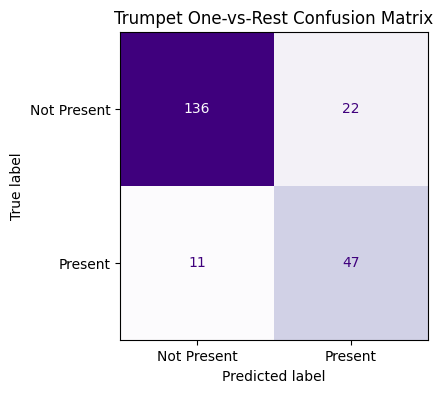


🎯 Clarinet-specific metrics:
Precision: 0.684
Recall:    0.520
F1-score:  0.591
PR-AUC:    0.665
Support (Clarinet samples): 50


In [50]:
#VIEWEING THE METRICS

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_fscore_support, average_precision_score

# --- predictions (if not already loaded) ---
y_true = y_test.argmax(axis=1)
y_prob = model2.predict(X_test, verbose=0)
y_pred = y_prob.argmax(axis=1)

class_names = ['Clarinet','Saxophone','Flute','Trumpet']
clarinet_idx = 0

# --- overall classification report ---
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# --- overall confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Overall Confusion Matrix")
plt.show()

# --- one-vs-rest confusion matrices ---
for i, name in enumerate(class_names):
    y_true_bin = (y_true == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    cm_i = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
    disp_i = ConfusionMatrixDisplay(confusion_matrix=cm_i, display_labels=["Not Present","Present"])
    fig, ax = plt.subplots(figsize=(4,4))
    disp_i.plot(ax=ax, cmap="Purples", values_format="d", colorbar=False)
    plt.title(f"{name} One-vs-Rest Confusion Matrix")
    plt.show()

# --- clarinet-specific metrics ---
y_true_c = (y_true == clarinet_idx).astype(int)
y_pred_c = (y_pred == clarinet_idx).astype(int)
prec_c, rec_c, f1_c, _ = precision_recall_fscore_support(y_true_c, y_pred_c, average='binary', zero_division=0)
pr_auc_c = average_precision_score(y_true_c, y_prob[:, clarinet_idx])

print("\n🎯 Clarinet-specific metrics:")
print(f"Precision: {prec_c:.3f}")
print(f"Recall:    {rec_c:.3f}")
print(f"F1-score:  {f1_c:.3f}")
print(f"PR-AUC:    {pr_auc_c:.3f}")
print(f"Support (Clarinet samples): {y_true_c.sum()}")